In [1]:
import pandas as pd
import numpy as np
import calendar

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Sales Train

In [2]:
sales_val = pd.read_csv("../../Data/sales_train_validation.csv")
sales_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [3]:
sales_val['id'].unique().shape

(30490,)

In [12]:
sales_val = (
    sales_val
    .melt(
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],  
        var_name='day',     
        value_name='sales'  
    )
    .assign(date = lambda x: pd.to_datetime('2011-01-28') + pd.to_timedelta(x['day'].str[2:].astype(int), unit='D'))
    .assign(year = lambda x: x['date'].dt.year)
    .assign(month = lambda x: x['date'].dt.month)
    .assign(day_of_month = lambda x: x['date'].dt.day)
    .assign(day_of_week = lambda x: x["date"].dt.dayofweek)
)

In [13]:
sales_val.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,date,year,month,day_of_month,day_of_week
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,2016,4,24,6
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,2016,4,24,6
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,2016,4,24,6
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,2016,4,24,6
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,2016,4,24,6


In [14]:
sales_val['store_id'].value_counts()

store_id
CA_1    5832737
CA_2    5832737
CA_3    5832737
CA_4    5832737
TX_1    5832737
TX_2    5832737
TX_3    5832737
WI_1    5832737
WI_2    5832737
WI_3    5832737
Name: count, dtype: int64

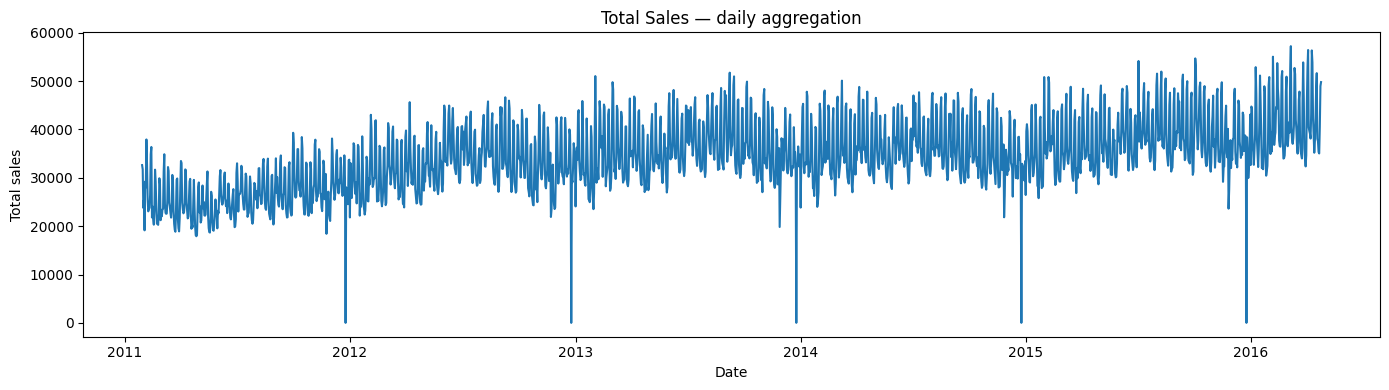

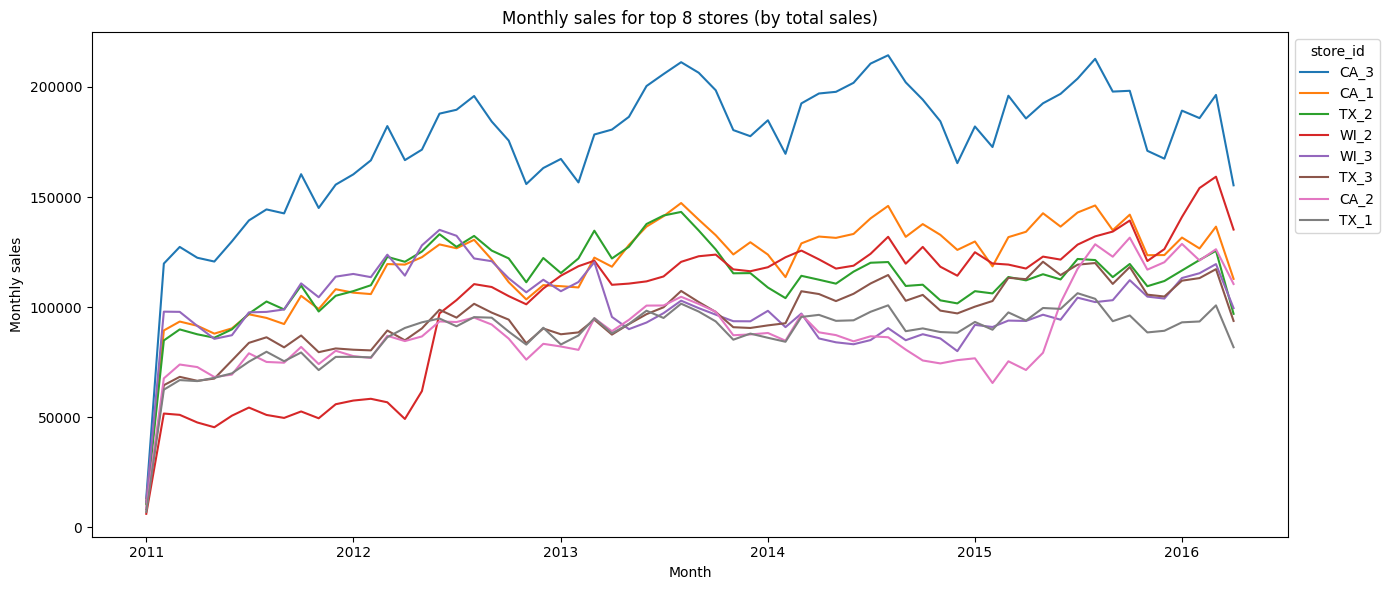

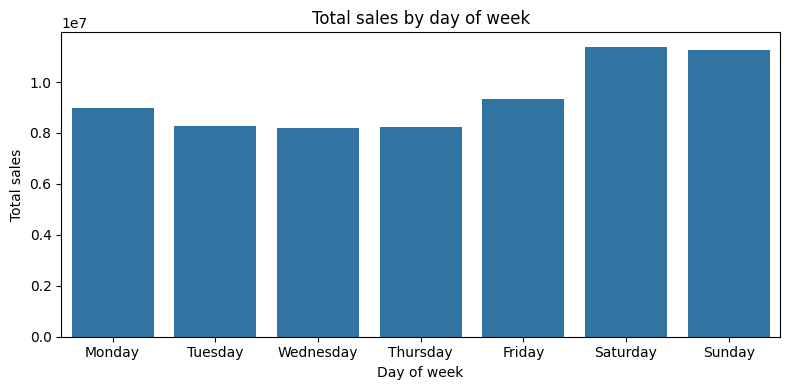

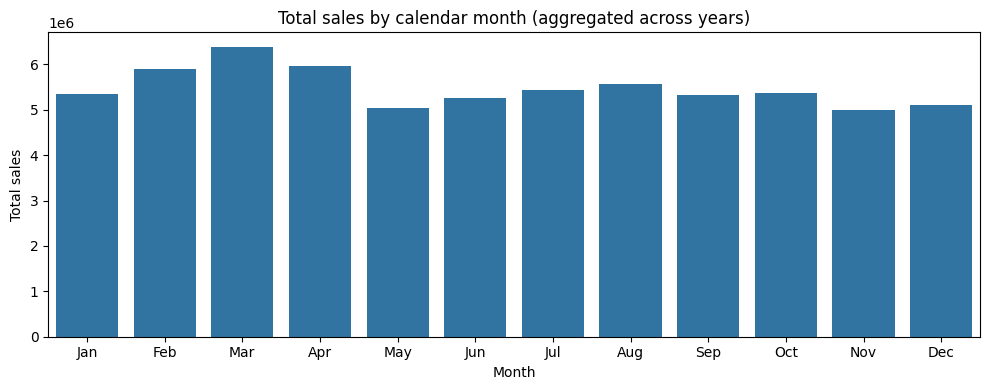

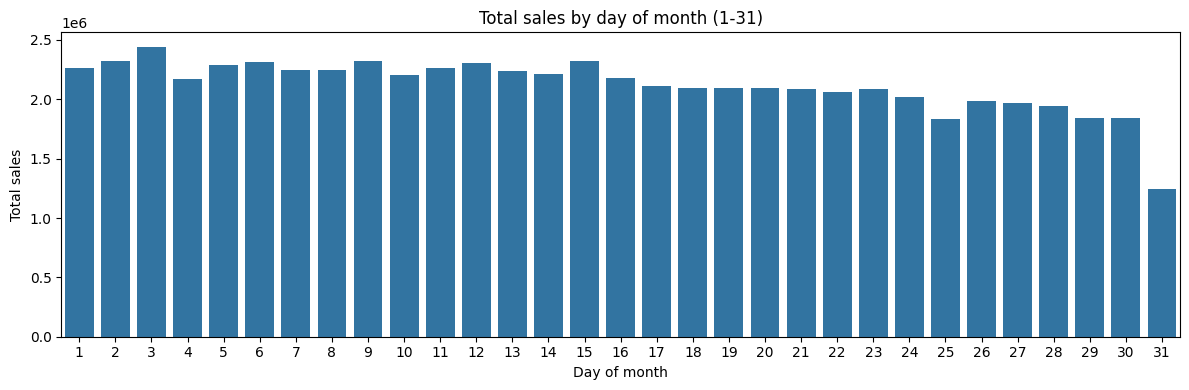

In [15]:
# ---------------- PLOT 1: overall sales progression aggregated by day ----------------
daily = sales_val.groupby('date', as_index=True)['sales'].sum().sort_index()

plt.figure(figsize=(14,4))
sns.lineplot(x=daily.index, y=daily.values)
plt.title('Total Sales — daily aggregation')
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.tight_layout()
plt.show()


# --------------- PLOT 2: overall progression aggregated by store_id, month ---------------
# monthly period start
sales_val['month_start'] = sales_val['date'].dt.to_period('M').dt.to_timestamp()
store_month = sales_val.groupby(['store_id','month_start'])['sales'].sum().reset_index()

# pivot so each store is a column
pivot = store_month.pivot(index='month_start', columns='store_id', values='sales').fillna(0)

# Plot only top N stores by total sales to avoid an unreadable plot
TOP_N = 8
top_stores = pivot.sum().nlargest(TOP_N).index.tolist()

plt.figure(figsize=(14,6))
for s in top_stores:
    sns.lineplot(x=pivot.index, y=pivot[s], label=s)
plt.legend(title='store_id', loc='upper left', bbox_to_anchor=(1,1))
plt.title(f'Monthly sales for top {TOP_N} stores (by total sales)')
plt.xlabel('Month')
plt.ylabel('Monthly sales')
plt.tight_layout()
plt.show()

# ------------- PLOT 3: overall sales progression aggregated by day_of_week -------------
dow = sales_val.groupby('day_of_week', as_index=False)['sales'].sum()

# Try to create readable weekday labels. We assume pandas weekday (0=Mon..6=Sun).
dow = dow.sort_values('day_of_week')
weekday_labels = [calendar.day_name[i % 7] for i in dow['day_of_week'].tolist()]

plt.figure(figsize=(8,4))
sns.barplot(x=dow['day_of_week'], y=dow['sales'])
plt.xticks(ticks=range(len(weekday_labels)), labels=weekday_labels)
plt.title('Total sales by day of week')
plt.xlabel('Day of week')
plt.ylabel('Total sales')
plt.tight_layout()
plt.show()

# ---------------- PLOT 4: sales aggregated by month-of-year (Jan..Dec) — seasonal view ----------------
monthly_of_year = sales_val.groupby(sales_val['month'])['sales'].sum().reindex(range(1,13)).fillna(0)

plt.figure(figsize=(10,4))
sns.barplot(x=list(range(1,13)), y=monthly_of_year.values)
plt.xticks(ticks=list(range(12)), labels=[calendar.month_abbr[i] for i in range(1,13)])
plt.title('Total sales by calendar month (aggregated across years)')
plt.xlabel('Month')
plt.ylabel('Total sales')
plt.tight_layout()
plt.show()


# ---------------- PLOT 5: overall sales aggregated by day_of_month ----------------
dom = sales_val.groupby('day_of_month')['sales'].sum().reindex(range(1,32)).fillna(0)

plt.figure(figsize=(12,4))
sns.barplot(x=dom.index, y=dom.values)
plt.title('Total sales by day of month (1-31)')
plt.xlabel('Day of month')
plt.ylabel('Total sales')
plt.tight_layout()
plt.show()


- Outliers: once per year there are no sales (probably the shops are closed)

- There is an overall upward trend

- Weekly seasonality: more sales during weekends

- Yearly seasonality: not clear

- Monthly seasonality: there is more spending during the first days of the month

In [16]:
# Basic stats
print(f"Rows: {len(sales_val)}, Unique items: {sales_val['item_id'].nunique()}, "
      f"Unique depts: {sales_val['dept_id'].nunique()}, Unique cats: {sales_val['cat_id'].nunique()}")

max_date = sales_val['date'].max()
min_date = sales_val['date'].min()
print(f"Date range from {min_date.date()} to {max_date.date()}")

# ---------- 1) What categories & how many items in each ----------
# Unique item count per category
items_per_cat = sales_val.groupby('cat_id')['item_id'].nunique().sort_values(ascending=False)
items_per_dept = sales_val.groupby('dept_id')['item_id'].nunique().sort_values(ascending=False)

# DataFrames for display
items_per_cat_sales_val = items_per_cat.reset_index().rename(columns={'item_id': 'n_items'})
items_per_dept_sales_val = items_per_dept.reset_index().rename(columns={'item_id': 'n_items'})

print("\nTop categories by number of items:")
print(items_per_cat_sales_val.head(20))

print("\nTop departments by number of items:")
print(items_per_dept_sales_val.head(20))

# ---------- 2) Aggregate total sales per category and per department ----------
# Sum of sales per category / department
sales_per_cat = (
    sales_val.groupby('cat_id')['sales']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'sales': 'total_sales'})
)

sales_per_dept = (
    sales_val.groupby('dept_id')['sales']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'sales': 'total_sales'})
)

print("\nTop categories by total sales:")
print(sales_per_cat.head(20))

print("\nTop departments by total sales:")
print(sales_per_dept.head(20))

Rows: 58327370, Unique items: 3049, Unique depts: 7, Unique cats: 3
Date range from 2011-01-29 to 2016-04-24

Top categories by number of items:
      cat_id  n_items
0      FOODS     1437
1  HOUSEHOLD     1047
2    HOBBIES      565

Top departments by number of items:
       dept_id  n_items
0      FOODS_3      823
1  HOUSEHOLD_1      532
2  HOUSEHOLD_2      515
3    HOBBIES_1      416
4      FOODS_2      398
5      FOODS_1      216
6    HOBBIES_2      149

Top categories by total sales:
      cat_id  total_sales
0      FOODS     45089939
1  HOUSEHOLD     14480670
2    HOBBIES      6124800

Top departments by total sales:
       dept_id  total_sales
0      FOODS_3     32372076
1  HOUSEHOLD_1     11500526
2      FOODS_2      7629822
3    HOBBIES_1      5596460
4      FOODS_1      5088041
5  HOUSEHOLD_2      2980144
6    HOBBIES_2       528340


- 50% of items are food, 32% household, 16% hobbies

- a huge majority of items sold are food

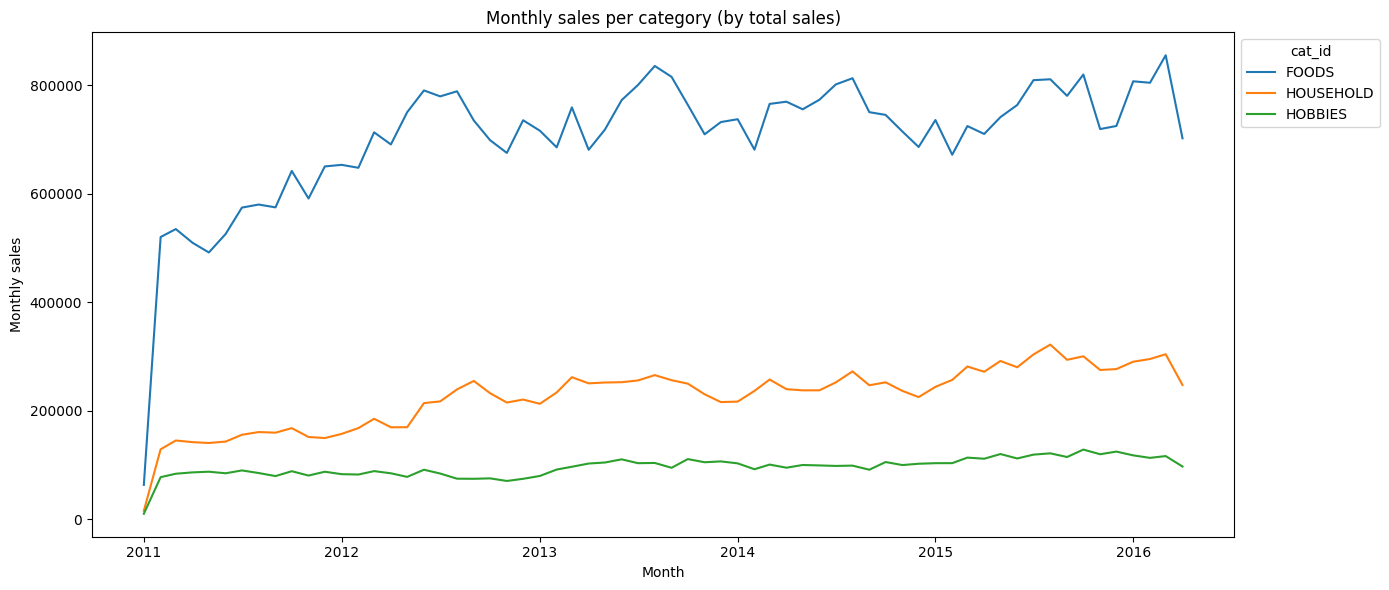

In [17]:
# --------------- PLOT: overall progression aggregated by cat_id, month ---------------

# Ensure month_start exists
sales_val['month_start'] = sales_val['date'].dt.to_period('M').dt.to_timestamp()

# Aggregate monthly sales per category
cat_month = (
    sales_val.groupby(['cat_id', 'month_start'])['sales']
    .sum()
    .reset_index()
)

# Pivot so each category is a column
pivot_cat = cat_month.pivot(index='month_start', columns='cat_id', values='sales').fillna(0)

# Plot only top N categories by total sales
TOP_N = 8
top_cats = pivot_cat.sum().nlargest(TOP_N).index.tolist()

plt.figure(figsize=(14,6))
for c in top_cats:
    sns.lineplot(x=pivot_cat.index, y=pivot_cat[c], label=c)

plt.legend(title='cat_id', loc='upper left', bbox_to_anchor=(1,1))
plt.title(f'Monthly sales per category (by total sales)')
plt.xlabel('Month')
plt.ylabel('Monthly sales')
plt.tight_layout()
plt.show()

- Sales seems to be somewhat constant after 2013 with some seasonality

In [18]:
# ---------- Are there food items that stopped appearing? ----------
# We'll compute first_date and last_date per item, plus total observations and total sales.
item_times = (sales_val.groupby('item_id')
                .agg(first_date=('date','min'),
                     last_date=('date','max'),
                     n_records=('date','count'),
                     total_sales=('sales','sum'))
                .reset_index())

# Heuristics: (1) Strict: last_date < max_date (not present on the very last day)
strict_discontinued = item_times[item_times['last_date'] < max_date].copy()

# (2) Pragmatic: last_date < (max_date - threshold_days)
threshold_days = 90   # <-- adjust as needed
threshold_date = max_date - pd.Timedelta(days=threshold_days)
pragmatic_discontinued = item_times[item_times['last_date'] < threshold_date].copy()

# Print counts
print(f"\nItems whose last_date < dataset max_date (strict): {len(strict_discontinued)}")
print(f"Items whose last_date < {threshold_days} days before max_date ({threshold_date.date()}): {len(pragmatic_discontinued)}")


Items whose last_date < dataset max_date (strict): 0
Items whose last_date < 90 days before max_date (2016-01-25): 0


- No items were discontinued

Ideas:

- Check outliers (days where sales in a shop were zero)

- Make it stationary, apply log

In [19]:
sales_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,date,year,month,day_of_month,day_of_week,month_start
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,1,29,5,2011-01-01
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,1,29,5,2011-01-01
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,1,29,5,2011-01-01
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,1,29,5,2011-01-01
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,2011,1,29,5,2011-01-01


In [25]:
outliers = (
    sales_val
    .groupby(['store_id', 'day'])['sales']
    .sum()
    .reset_index()
    .loc[lambda x: x['sales'] == 0, :]
    [['store_id', 'day']]
)
outliers.head()

,store_id,day
71,CA_1,d_1062
476,CA_1,d_1427
881,CA_1,d_1792
1172,CA_1,d_331
1577,CA_1,d_697
